> This project is a Python application for extracting data from passport images. It utilizes Optical Character Recognition (OCR) to read information from Machine Readable Zones (MRZ) and other parts of the passport.

#### Features

* Extracts data from the MRZ (Machine Readable Zone) of the passport.
* Finds the issuing authority and date of issue.
* Uses EasyOCR for text recognition.
* Handles country codes and date parsing.


**Install the required Python packages:**

In [1]:
!pip install pytesseract  
!sudo apt install tesseract-ocr
!pip install easyocr
!pip install PassportEye





tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for PassportEye: filename=PassportEye-2.2.1-py3-none-any.whl size=29596 sha256=d1c8562f3a554b51cced45aebcc1b5526fa44299f01bca02d0abd3775bc99cdd
  Stored in directory: /root/.cache/pip/wheels/77/4b/01/d43db9410eef3e79a211a78f7ccb04af864a97b61aeee0bf88
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140080 sha256=9a74c0a1bc1aa14fc93145d0cc7f6516d935b6471d25365f5ef5e0c327d05874
  Stored in directory: /root/.cache/pip/wheels/4e/c1/68/f7bd0a8f514661f76b5cbe3b5f76e0033d79f1296012cbbf72
Successfully built PassportEye pdfminer


In [2]:
import os
import string as st
from dateutil import parser
import matplotlib.image as mpimg
import cv2
from passporteye import read_mrz
import json
import easyocr
import warnings
import tempfile
import re
from IPython.display import Image


warnings.filterwarnings('ignore')

In [3]:
class PassportDataExtractor:
    def __init__(self, country_codes_file, gpu=True):
        self.reader = easyocr.Reader(lang_list=['en'], gpu=gpu)
        with open(country_codes_file) as f:
            self.country_codes = json.load(f)

    def parse_birth_date(self, date_string):
        try:
            # Parse the date assuming the year is in the range 1900-2099
            date = parser.parse(date_string, yearfirst=True).date()
            # Adjust the year if it falls outside the expected range
            if date.year >= 2000:
                date = date.replace(year=date.year - 100)
            return date.strftime('%d/%m/%Y')
        except ValueError:
            return None

    def parse_date(self, date_string):
        try:
            # Parse the date assuming the year is in the range 1900-2099
            date = parser.parse(date_string, yearfirst=True).date()
            return date.strftime('%d/%m/%Y')
        except ValueError:
            return None

    def clean(self, string):
        return ''.join(char for char in string if char.isalnum()).upper()

    def get_country_name(self, country_code):
        for country in self.country_codes:
            if country['code'] == country_code:
                return country['name']
        return country_code

    def find_authority(self, ocr_text):
        keywords = ['ISSUING AUTHORITY', 'ISSUED BY', 'AUTHORITY', 'ISSUING OFFICE', 'PLACE OF ISSUE']
        for line in ocr_text:
            for keyword in keywords:
                if keyword in line.upper():
                    authority = line.upper().split(keyword)[-1].strip()
                    return authority
        return 'Not Found'

    def find_issuing_date(self, ocr_text):
        date_patterns = [
            r'\d{2}[-/]\d{2}[-/]\d{2,4}',  # Matches 'DD-MM-YYYY' or 'DD/MM/YY'
            r'\d{2} \d{2} \d{4}',  
            r'\d{2} \b(?:JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC)\b \d{4}',  # Matches 'DD MMM YYYY'
        ]

        dates = set()

        for line in ocr_text:
            for pattern in date_patterns:
                date_matches = re.findall(pattern, line, re.IGNORECASE)
                for date_match in date_matches:
                    parsed_date = self.parse_date(date_match)
                    if parsed_date:
                        dates.add(parsed_date)

        if len(dates) >= 3:
            dates = sorted(dates, key=lambda x: parser.parse(x, dayfirst=True))
            return dates[1]  # Return the middle date
        return 'Not Found'

    def print_data(self, data):
        for key, value in data.items():
            print(f'{key.replace("_", " ").capitalize()}\t:\t{value}')

    def get_data(self, img_name):
        user_info = {}
        with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmpfile:
            tmpfile_path = tmpfile.name

        try:
            mrz = read_mrz(img_name, save_roi=True)
            if mrz:
                mpimg.imsave(tmpfile_path, mrz.aux['roi'], cmap='gray')
                img = cv2.imread(tmpfile_path)
                img = cv2.resize(img, (1110, 140))
                allowlist = st.ascii_letters + st.digits + '< '
                code = self.reader.readtext(img, paragraph=False, detail=0, allowlist=allowlist)

                if len(code) < 2:
                    return print(f'Error: Insufficient OCR results for image {img_name}.')

                a, b = code[0].upper(), code[1].upper()

                if len(a) < 44:
                    a = a + '<' * (44 - len(a))
                if len(b) < 44:
                    b = b + '<' * (44 - len(b))

                surname_names = a[5:44].split('<<', 1)
                surname, names = surname_names if len(surname_names) == 2 else (surname_names[0], '')
                name = names.replace('<', ' ').strip().upper()
                surname = surname.replace('<', ' ').strip().upper()
              
                full_img = cv2.imread(img_name)
                ocr_results = self.reader.readtext(full_img, detail=0)
              
                user_info['Name'] = f"{name} {surname}"
                user_info['Date of Birth'] = self.parse_birth_date(b[13:19])
                user_info['Date of Issue'] = self.find_issuing_date(ocr_results)
                user_info['Date of Expiry'] = self.parse_date(b[21:27])
                user_info['Authority'] = self.find_authority(ocr_results)
                user_info['Nationality'] = self.get_country_name(self.clean(b[10:13]))
                user_info['Passport Type'] = self.clean(a[0:2])
                user_info['Passport Number'] = self.clean(b[0:9])


            else:
                print(f'Machine cannot read image {img_name}.')

        finally:
            if os.path.exists(tmpfile_path):
                os.remove(tmpfile_path)

        return user_info

# Example

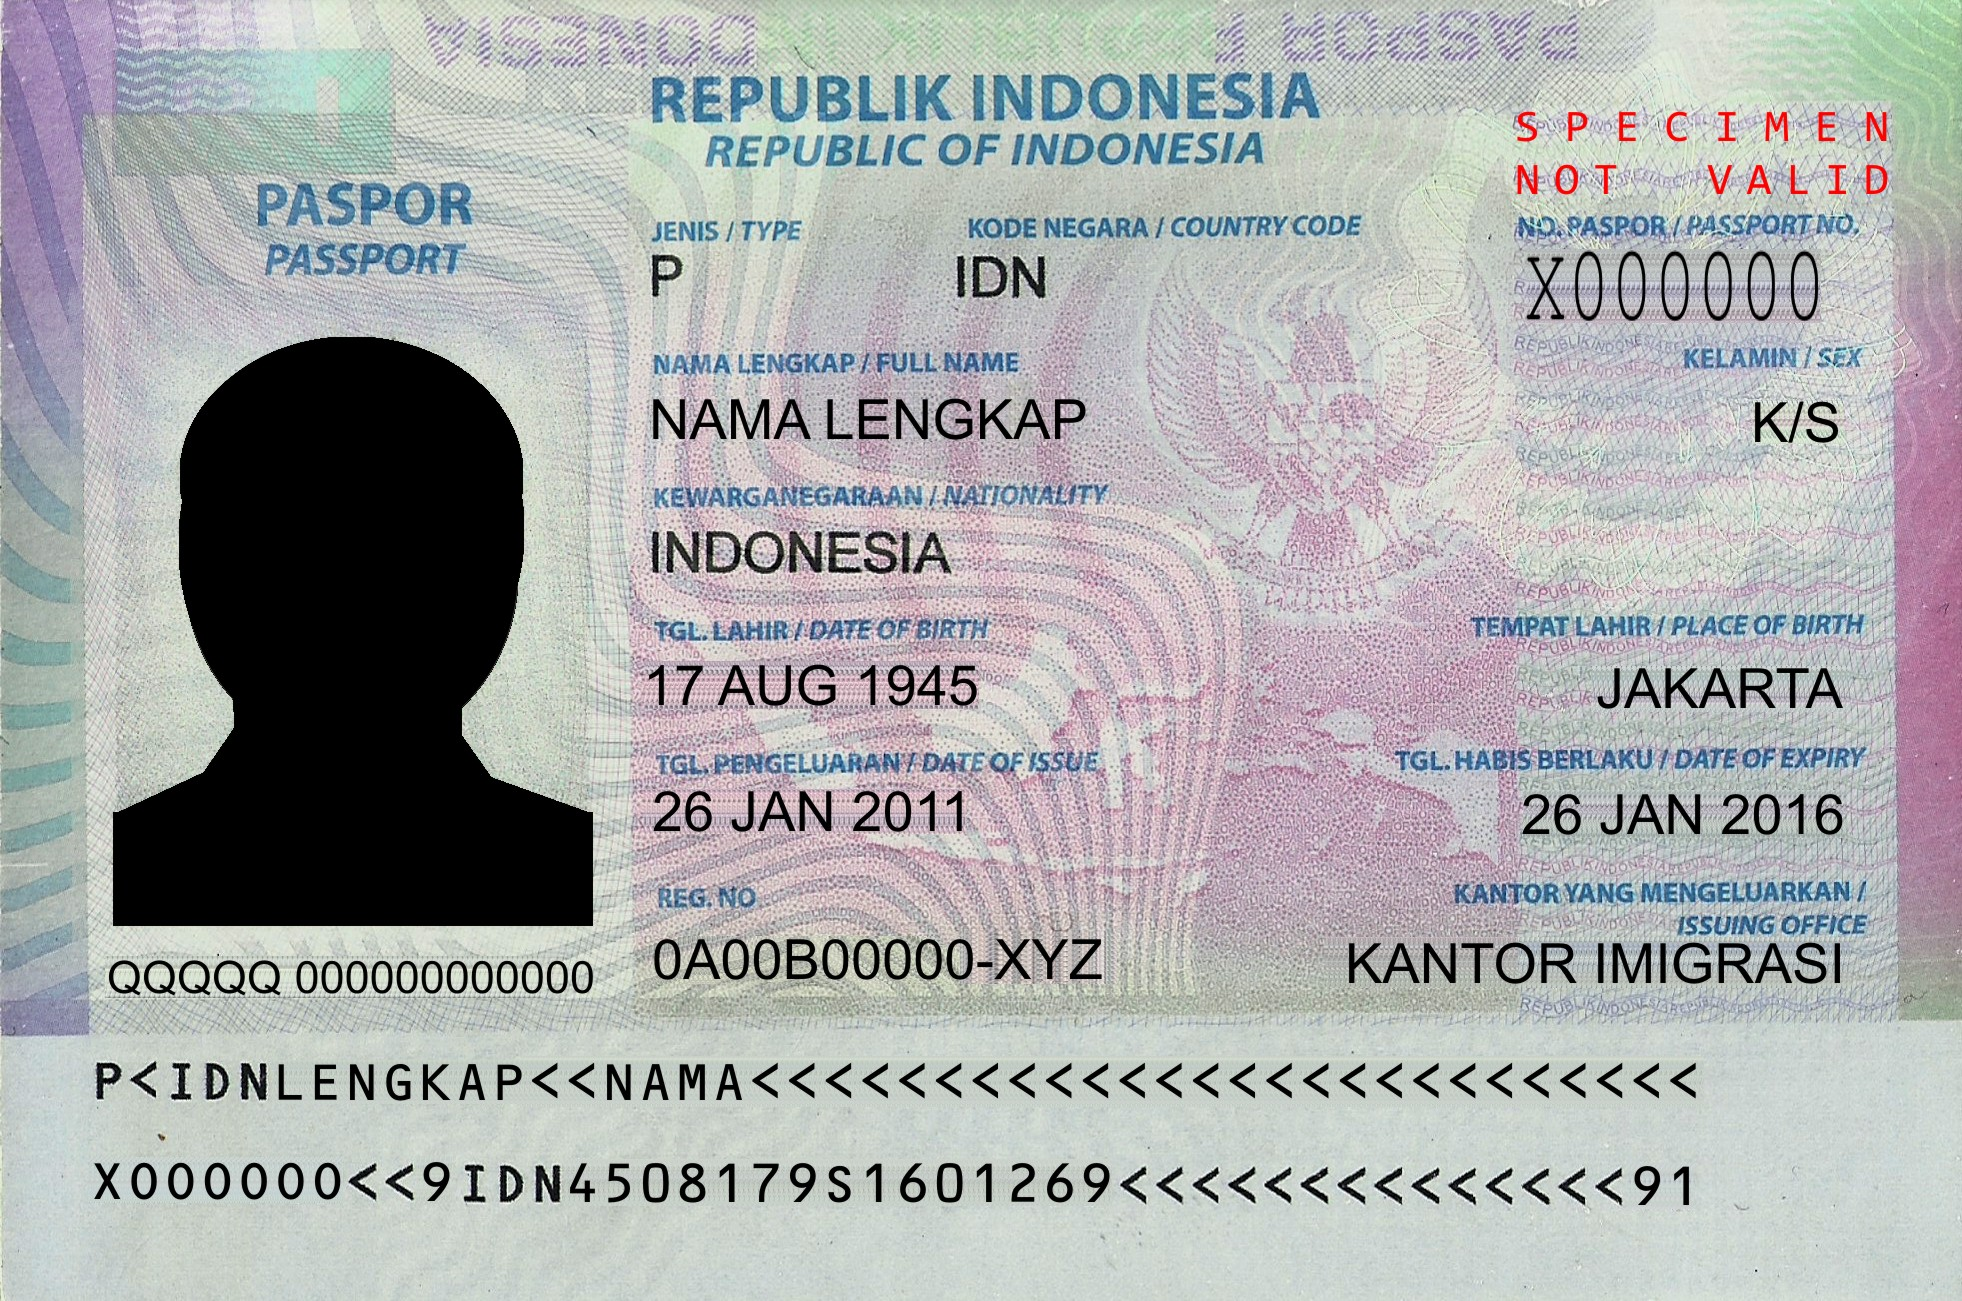

In [4]:
Image(filename="/kaggle/input/passport-dataset/Indonesia.jpg")

In [5]:
# Usage Example
if __name__ == "__main__":
    country_codes_file = '/kaggle/input/passport-dataset/country_codes.json'
    img_name = '/kaggle/input/passport-dataset/Indonesia.jpg'
    extractor = PassportDataExtractor(country_codes_file)
    data = extractor.get_data(img_name)
    extractor.print_data(data)

Name	:	NAMA LENGKAP
Date of birth	:	17/08/1945
Date of issue	:	26/01/2011
Date of expiry	:	26/01/2016
Authority	:	
Nationality	:	Indonesia
Passport type	:	P
Passport number	:	X00000O
